**Version:**   
NetworkX 2.2 or higher

In [1]:
import pandas as pd
import networkx as nx

nx.__version__

'2.3'

# Data
- Link Information (Reference Relationship of PEPs)
    - adjacency_matrix.csv
- PEP Headers
    - pep_header.csv

In [2]:
%ls ../data/input/20190401

adjacency_matrix.csv  pep_header.csv


# Make a Network Structure Data from Link Information
## Link Information (Reference Relationship of PEPs)
<img src="../images/links.png">
<img src="../images/arrow.png">
<img src="../images/pep_graph.png">

## Data Representation
The network structure is represented by an adjacency matrix or edge list.   
Here we use the adjacency matrix.   

<img src="../images/adj_matrix_and_edge_list.png">

## Load and Preprocess

In [3]:
adj_df = pd.read_csv('../data/input/20190401/adjacency_matrix.csv',
                     encoding='utf-8',
                     dtype=dict(link_source_pep_id=str))
adj_df = adj_df.set_index('link_source_pep_id')
print(adj_df.shape)
adj_df.head(5)

(486, 486)


,0001,0002,0003,0004,0005,0006,0007,0008,0009,0010,...,8001,8002,8010,8011,8012,8013,8014,8015,8016,8100
link_source_pep_id,,,,,,,,,,,,,,,,,,,,,
0001,1,3,0,0,0,0,2,2,3,0,...,0,0,0,0,0,0,0,0,0,0
0002,2,0,1,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Weight isn't considered this time. So, replace it with 1.

In [4]:
adj_df = adj_df.mask(adj_df > 0).fillna(1).astype(int)
adj_df.head(5)

,0001,0002,0003,0004,0005,0006,0007,0008,0009,0010,...,8001,8002,8010,8011,8012,8013,8014,8015,8016,8100
link_source_pep_id,,,,,,,,,,,,,,,,,,,,,
0001,1,1,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
0002,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Convert Pandas to NetworkX

### Convert
NetworkX has functions to convert various data into graph structure.   

** Converting to and from other data formats**   
https://networkx.github.io/documentation/stable/reference/convert.html   


If you want to convert pandas DataFrame, you can use `from_pandas_adjacency` or `from_pandas_edgelist`.   
Here, let us introduce the cases of using `from_pandas_adjacency`.

** nx.from_pandas_adjacency **   
- https://networkx.github.io/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_adjacency.html

In [5]:
# Convert
pep_graph = nx.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)
print(nx.info(pep_graph))

Name: 
Type: DiGraph
Number of nodes: 486
Number of edges: 1037
Average in degree:   2.1337
Average out degree:   2.1337


### Preprocess (Remove Self-loop)

<img src="../images/self-loop.png">

This case doesn't deal with self-loops. Therefore, remove them as follows.

In [6]:
def remove_self_loop(source_graph):
    # Get self-loop edge
    self_loop_edges = [(start, end) for start, end in source_graph.edges() if start == end]
    print('self loop: {}'.format(len(self_loop_edges)))

    # Remove
    for start, end in self_loop_edges:
        source_graph.remove_edge(start, end)

remove_self_loop(pep_graph)

# Confirm
print(nx.info(pep_graph))

self loop: 73
Name: 
Type: DiGraph
Number of nodes: 486
Number of edges: 964
Average in degree:   1.9835
Average out degree:   1.9835


73 self-loops were found and removed.   
The number of edges decreased from 1037 to 964.

### Confirm

In [7]:
# Confirm Nodes
list(pep_graph.nodes())[:5]

['0001', '0002', '0003', '0004', '0005']

In [8]:
# Confirm edges connected to '"PEP 1" node
pep_graph['0001']

AtlasView({'0002': {'weight': 1}, '0007': {'weight': 1}, '0008': {'weight': 1}, '0009': {'weight': 1}, '0012': {'weight': 1}, '0013': {'weight': 1}, '0411': {'weight': 1}})

# Set PEP Headers as Node Attributes
## PEP Headers
PEP headers are written at the beginning of each PEP page.   

<img src="../images/pep_header.png">

The specification is defined in PEP 1.

**PEP 1 -- PEP Purpose and Guidelines**   
https://www.python.org/dev/peps/pep-0001/#pep-header-preamble

## Load

In [9]:
path = '../data/input/20190401/pep_header.csv'
header_df = pd.read_csv(path,
                        encoding='utf-8',
                        dtype=dict(pep_id=str),
                        parse_dates=['Created_dt'])
header_df = header_df.set_index('pep_id')
header_df.head(3)

,Author,BDFL-Delegate,Created,Created_dt,Discussions-To,Last-Modified,PEP,Post-History,Python-Version,Replaces,Requires,Resolution,Sponsor,Status,Superseded-By,Title,Type,Version
pep_id,,,,,,,,,,,,,,,,,,
0515,"Georg Brandl, Serhiy Storchaka",NaN,10-Feb-2016,2016-02-10,NaN,NaN,515,"10-Feb-2016, 11-Feb-2016",3.6,NaN,NaN,NaN,NaN,Final,NaN,Underscores in Numeric Literals,Standards Track,NaN
0483,"Guido van Rossum <guido at python.org>, Ivan L...",NaN,19-Dec-2014,2014-12-19,Python-Ideas <python-ideas at python.org>,NaN,483,NaN,NaN,NaN,NaN,NaN,NaN,Final,NaN,The Theory of Type Hints,Informational,NaN
0403,Nick Coghlan <ncoghlan at gmail.com>,NaN,2011-10-13,2011-10-13,NaN,NaN,403,2011-10-13,3.4,NaN,NaN,TBD,NaN,Deferred,NaN,"General purpose decorator clause (aka ""@in"" cl...",Standards Track,NaN


## Confirm Columns

In [10]:
# Confirm all columns
list(header_df.columns)

['Author',
 'BDFL-Delegate',
 'Created',
 'Created_dt',
 'Discussions-To',
 'Last-Modified',
 'PEP',
 'Post-History',
 'Python-Version',
 'Replaces',
 'Requires',
 'Resolution',
 'Sponsor',
 'Status',
 'Superseded-By',
 'Title',
 'Type',
 'Version']

The following 4 columns are mainly used this time.

- Title
- Type
- Status
- Created

### Title
- e.g.
    - Style Guide for Python Code
    - PEP Purpose and Guidelines
    - Type Hints

### Type
** See Also: 'PEP Types' in PEP 1**   
https://www.python.org/dev/peps/pep-0001/#pep-types

- **Standards Track**
    - PEPs describing a new features or implementation for Python
    - e.g.
        + PEP 484 Type Hints
        + PEP 428 The pathlib module -- object-oriented filesystem paths
- **Informational**
    - PEPs describing a Python design issue, or providing general guidelines or information to the Python community. But they doesn't propose new features. 
    - e.g.
        + PEP 537 Python 3.7 Release Schedule
        + PEP 483 The Theory of Type Hints
- **Process**
    - describes a process surrounding Python, or proposes a change to (or an event in) a process.
    - e.g.
        + PEP 1 Purpose and Guidelines
        + PEP 545 Python Documentation Translations

In [11]:
work_df = pd.DataFrame(header_df.groupby('Type').size().sort_values(ascending=False))
work_df = work_df.rename(columns={0: 'peps'})
work_df.style.bar(color='#5fba7d')

,peps
Type,
Standards Track,369
Informational,75
Process,42


### Status
**See Also: 'PEP Workflow' in PEP 1**   
https://www.python.org/dev/peps/pep-0001/#pep-workflow

<img src="../images/pep_flow.png">

In [12]:
work_df = pd.DataFrame(header_df.groupby('Status').size().sort_values(ascending=False))
work_df = work_df.rename(columns={0: 'peps'})
work_df.style.bar(color='#5fba7d')

,peps
Status,
Final,219
Rejected,100
Withdrawn,46
Deferred,37
Active,31
Draft,30
Accepted,10
Superseded,9
Provisional,3


#### Status: April Fool!

** PEP 401 -- BDFL Retirement **   
https://www.python.org/dev/peps/pep-0401/   

joke PEP
> Guido leaves Python in the good hands of its new leader and its vibrant community, in order to train for his lifelong dream of climbing Mount Everest.

### Created (and Created_dt)
- Created
    - date created on
    - raw data
- Created_dt
    - Preprocessed data

In [13]:
header_df[['Created', 'Created_dt']].head(5)

,Created,Created_dt
pep_id,,
0515,10-Feb-2016,2016-02-10
0483,19-Dec-2014,2014-12-19
0403,2011-10-13,2011-10-13
0268,20-Aug-2001,2001-08-20
0244,20-Mar-2001,2001-03-20


In [14]:
header_df[['Created', 'Created_dt']].dtypes

Created               object
Created_dt    datetime64[ns]
dtype: object

#### total peps in year

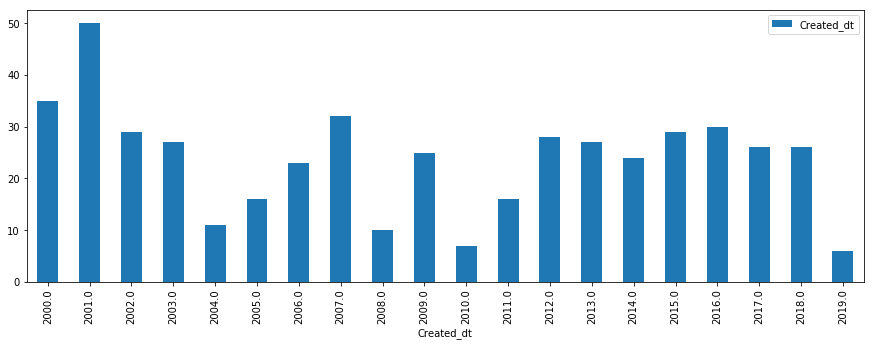

In [15]:
# total peps in year
temp_df = header_df.copy()
temp_df = temp_df[['Created_dt']]
temp_df["Created_dt"] = temp_df["Created_dt"].astype("datetime64")
temp_df.groupby(temp_df["Created_dt"].dt.year).count().plot(kind="bar", figsize=(15, 5))

### Set node attributes
**nx.set_node_attributes function**   
https://networkx.github.io/documentation/stable/reference/generated/networkx.classes.function.set_node_attributes.html

<img src="../images/set_node_attributes.png">

In [16]:
print('Before')
pep_graph.nodes['0001']

Before


{}

In [17]:
for column_name, series in header_df.iteritems():
    nx.set_node_attributes(pep_graph, dict(series), column_name)

print('After')
pep_graph.nodes['0001']

After


{'Author': 'Barry Warsaw, Jeremy Hylton, David Goodger, Nick Coghlan',
 'BDFL-Delegate': nan,
 'Created': '13-Jun-2000',
 'Created_dt': Timestamp('2000-06-13 00:00:00'),
 'Discussions-To': nan,
 'Last-Modified': nan,
 'PEP': 1,
 'Post-History': '21-Mar-2001, 29-Jul-2002, 03-May-2003, 05-May-2012,\n07-Apr-2013',
 'Python-Version': nan,
 'Replaces': nan,
 'Requires': nan,
 'Resolution': nan,
 'Sponsor': nan,
 'Status': 'Active',
 'Superseded-By': nan,
 'Title': 'PEP Purpose and Guidelines',
 'Type': 'Process',
 'Version': nan}

# Save Graph
In the next notebook (`02-draw_network.ipynb`), we will draw the network structure.     
Save the data using NetworkX functions for the next notebook.

NetworkX has functions to save graph data in various formats.

** Reading and writing graphs **
https://networkx.github.io/documentation/stable/reference/readwrite/index.html

In [18]:
# Save
nx.write_gpickle(pep_graph, '../data/output/pep_graph.gpickle')